In [2]:
import networkx as nx
from itertools import product
from typing import List, Tuple, Dict
import json
import random
import sympy as sp
import numpy as np

from routing_game_utils import *

In [3]:
softmax(np.array([0, 0]))

array([0.5, 0.5])

In [4]:
def get_derivative_function(expression_str, variable='x'):    
    # define variable, parse expression
    x = sp.symbols(variable)
    expression = sp.sympify(expression_str)

    print(sp.lambdify(x, expression)(2))
    
    
    # differentiate expression w.r.t. x
    derivative_expr = sp.diff(expression, x)

    # convert derivative to python function
    derivative_func = sp.lambdify(x, derivative_expr, 'numpy')

    # print original + derivative for verifications purposes
    print(f"Original expression: {expression}")
    print(f"Derivative: {derivative_expr}")
    
    return derivative_func

In [5]:
get_derivative_function('x**2')

4
Original expression: x**2
Derivative: 2*x


<function _lambdifygenerated(x)>

In [83]:
def mixed(
    G: nx.DiGraph,
    source_sink_pairs: List[Tuple[int, int]],
    demands: List[int],
    latency_functions: Dict,
    max_iterations: int = 1000,
    learning_rate: float = .1,
    marginal_cost_pricing: bool = False,
    sensitivities: List[float] = None,
    verbose: bool = False
):
    # each player's strategy set is represented as a set of available paths from their source to their sink
    paths = get_strategy_sets(G, source_sink_pairs)
    num_players = len(source_sink_pairs)

    # start with no bias for any particular strategy
    logits = [np.array([1.0 for _ in range(len(player_path))]) for player_path in paths]

    # for each player, initialize to random strategy
    random.seed(10)
    current_flow = [random.randint(0, len(paths[player_idx]) - 1) for player_idx in range(num_players)]

    if verbose:
        print('paths ', paths)
        print('starting flow ', current_flow)
        
    iteration = 0

    # debugging information, to make sure players are picked uniformly at random
    picked_players = [0 for _ in range(num_players)]


    historical_avg = [0 for _ in range(num_players)]
    
    while iteration < max_iterations:
        
        if verbose:
            print('-' * 8, 'starting round: ', iteration, '-' * 8)
        iteration += 1

        # previous flows, latencies

        # TODO: can we reduce the amount of times this calculation is called so it's more efficient?
        if (marginal_cost_pricing):
            f_e, player_latencies, total_latency = calculate_edge_flows_taxed(paths, current_flow, demands, latency_functions, sensitivities)
        else:
            f_e, player_latencies, total_latency = calculate_edge_flows(paths, current_flow, demands, latency_functions)
        player_idx = random.randint(0, num_players - 1) # pick a random player
        picked_players[player_idx] += 1

        # get previous latency/path
        prev_latency = player_latencies[player_idx]
        prev_path_idx = current_flow[player_idx]
        prev_path = paths[player_idx][prev_path_idx]

        alpha = 0.2
        prev_utility = -1 * prev_latency

        # update the historical average
        historical_avg[player_idx] = (1 - alpha) * historical_avg[player_idx] + alpha * prev_utility
        
        # construct a new flow
        mixed_strat = softmax(logits[player_idx]) # get a player's mixed strategy from their logits

        # even if we were at the best move, and we pick a worse alternative
        # what would happen is that we would evaluate the alternative to be bad, lower its probability of happening
        # then maybe go back to the best, which by virtue of being the best, we would increase its probability of happening again
        # this way, good moves get rewarded, bad moves get punished probabilistically
        alternative_path_idx = sample_move_skip_index(mixed_strat, prev_path_idx) # pick some alternate move (no point of repeating current move)
        alternative_path = paths[player_idx][alternative_path_idx]
        if sensitivities:
            s_i = sensitivities[player_idx]
        else:
            s_i = 1

        # debugging information
        if verbose:
            print('picking player', player_idx)
            print('previous latency', prev_latency)
            print('prev path idx', prev_path_idx)
            print('alternative path idx', alternative_path_idx)
            print('alternative_path')

        # develop alternative path
        hypothetical_f_e = f_e.copy()
        demand = demands[player_idx]

        # constructing the alternative flow
        # step 1: Remove player's demand from the path's edges they are currently using
        for i in range(len(prev_path) - 1):
            edge = (prev_path[i], prev_path[i + 1])
            hypothetical_f_e[edge] -= demand

        # step 2: Add player's demand to alternative path edges
        for i in range(len(alternative_path) - 1):
            edge = (alternative_path[i], alternative_path[i + 1])
            hypothetical_f_e[edge] = hypothetical_f_e.get(edge, 0) + demand

        # step 3: Compute latency for the alternative path
        alternative_latency = 0
        for i in range(len(alternative_path) - 1):
            edge = (alternative_path[i], alternative_path[i + 1])
            congestion = hypothetical_f_e[edge]
            f, f_prime = latency_functions[edge]
            if marginal_cost_pricing:
                latency = f(congestion)
                tax = congestion * f_prime(congestion)
                edge_latency =  latency + s_i * tax
            else:
                edge_latency = f(congestion)
            alternative_latency += edge_latency
        
        alternative_util = -1 * alternative_latency

        # get difference between alternative utility and current utility
        # utility is -1 * latency
        # give logit a positive increase for good delta where alternative utility increased
        delta = alternative_util - historical_avg[player_idx]

        # debugging data
        if verbose:
            print('delta', delta)
            print('old logits: ', logits[player_idx])

        # update logits. positive delta = alternative was good, and should be picked more frequently in the future
        logits[player_idx][alternative_path_idx] += learning_rate * delta

        # debugging data
        if verbose:
            print('new logits: ', logits[player_idx])

        current_flow[player_idx] = alternative_path_idx

    # get final mixed strategy profile
    probabilities_profile = [softmax(player_logits) for player_logits in logits]
    # print(picked_players)
    # paths: strategy sets for each player
    # current_flow: the equilibrium flow. each idx represents a player, each value represents the strategy that the player picked (ex: strategy 0, 1, ...)
    # player_latencies: the latency of each player in the equilibrium flow
    # total latency: sum of player latencies
    return paths, probabilities_profile

In [33]:
def argmax_flow(probabilities_profile):
    flow = []
    for mixed in probabilities_profile:
        flow.append(int(np.argmax(mixed)))
    return flow

In [ ]:
def test(filename, marginal_cost_pricing=False):
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance(filename)
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 10000, .1, marginal_cost_pricing)
    flow = argmax_flow(probabilties_profile)

    f_e, player_latencies, total_latency = calculate_edge_flows(paths, flow, demands, latency_functions)
    
    if (marginal_cost_pricing):
        f_e_taxed, player_latencies_taxed, total_latency_taxed = calculate_edge_flows_taxed(paths, flow, demands, latency_functions)

        print('total latency taxed: ', total_latency_taxed)
    
    print('total latency untaxed: ', total_latency)

    print('argmax flow: ', flow)
    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

total latency untaxed:  128
argmax flow:  [1, 1, 1, 1, 1, 1, 1, 1]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([2.81952793e-40, 1.00000000e+00, 2.42849313e-40]), array([1.51756261e-39, 1.00000000e+00, 2.89238232e-39]), array([1.09064896e-39, 1.00000000e+00, 2.12217798e-39]), array([6.14850080e-39, 1.00000000e+00, 9.48046388e-39]), array([5.01429188e-41, 1.00000000e+00, 8.21815425e-41]), array([4.92673183e-42, 1.00000000e+00, 4.52455761e-42]), array([1.94671554e-41, 1.00000000e+00, 3.12553989e-41]), array([1.19508855e-38, 1.0000000

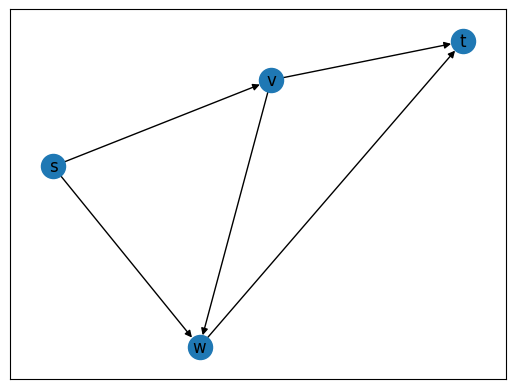

In [94]:
test('graph_examples/braess_paradox8.txt')

total latency taxed:  128
total latency untaxed:  96
argmax flow:  [0, 2, 0, 2, 0, 0, 2, 2]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([9.87137021e-01, 3.03562058e-06, 1.28599430e-02]), array([2.39776629e-10, 1.32001817e-10, 1.00000000e+00]), array([9.99999987e-01, 4.38248386e-11, 1.27588383e-08]), array([5.20635166e-07, 1.76115872e-10, 9.99999479e-01]), array([9.98123710e-01, 5.12225256e-06, 1.87116789e-03]), array([9.78036863e-01, 5.28328762e-05, 2.19103044e-02]), array([6.97801533e-05, 2.43697724e-07, 9.99929976e-01]), array([

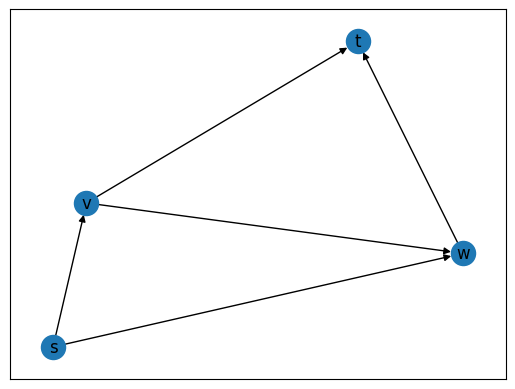

In [100]:
test('graph_examples/braess_paradox8.txt', True)

total latency untaxed:  800
argmax flow:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't

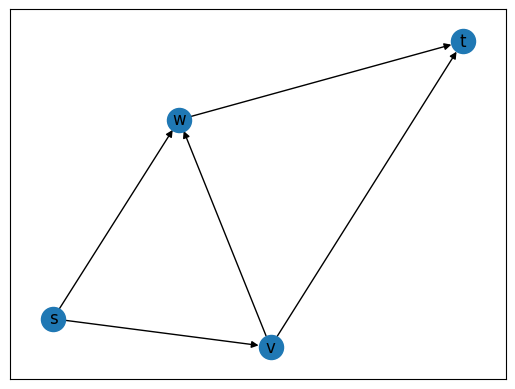

In [101]:
test('graph_examples/braess_paradox20.txt')

total latency taxed:  800
total latency untaxed:  600
argmax flow:  [2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 

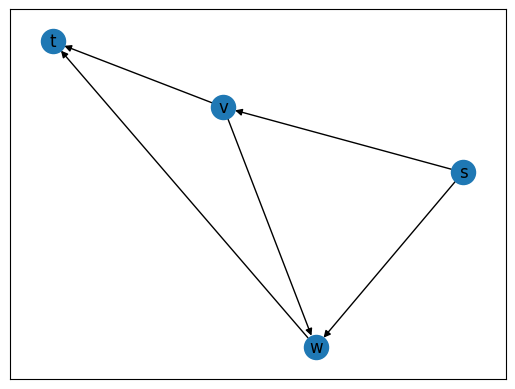

In [104]:
test('graph_examples/braess_paradox20.txt', True)

total latency untaxed:  8
argmax flow:  [1, 1]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([3.31877500e-05, 9.99966505e-01, 3.07483319e-07]), array([1.61902313e-06, 9.99818588e-01, 1.79793138e-04])]


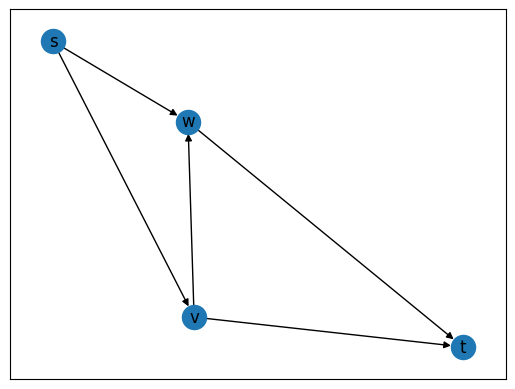

In [105]:
test('graph_examples/braess_paradox.txt')

total latency taxed:  8
total latency untaxed:  6
argmax flow:  [2, 0]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([4.81995340e-06, 2.97986227e-08, 9.99995150e-01]), array([1.00000000e+00, 3.32244574e-14, 1.47559787e-11])]


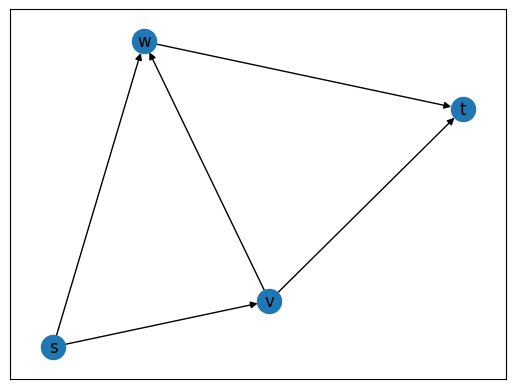

In [106]:
test('graph_examples/braess_paradox.txt', True)

In [41]:
def braess_paradox_mixed_taxed_sensitivites1():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 10000, .1, marginal_cost_pricing=True, sensitivities=[0, 1], verbose=False)
    print(argmax_flow(probabilties_profile))
    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[4906, 5094]
[1, 0]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([9.91582768e-45, 1.00000000e+00, 3.77263937e-45]), array([9.52399190e-01, 1.73598761e-05, 4.75834504e-02])]


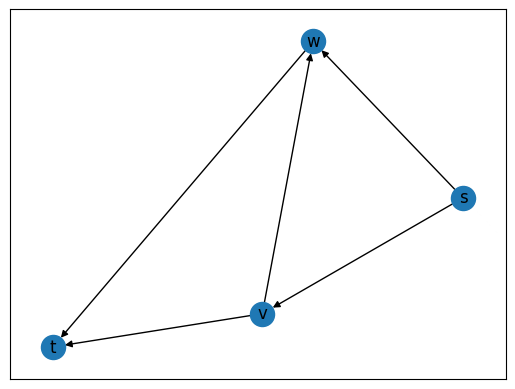

In [42]:
braess_paradox_mixed_taxed_sensitivites1()

In [46]:
def AAE_mixed():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/aae_example.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 1000, .1, verbose=False)
    print(argmax_flow(probabilties_profile))

    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[246, 248, 233, 273]
[0, 1, 1, 0]
All paths:  [[['u', 'v'], ['u', 'w', 'v']], [['u', 'v', 'w'], ['u', 'w']], [['v', 'u', 'w'], ['v', 'w']], [['w', 'v'], ['w', 'u', 'v']]]
Probabilities profile:  [array([1.00000000e+00, 4.09051972e-10]), array([1.07983891e-09, 9.99999999e-01]), array([0.00135747, 0.99864253]), array([0.99535656, 0.00464344])]


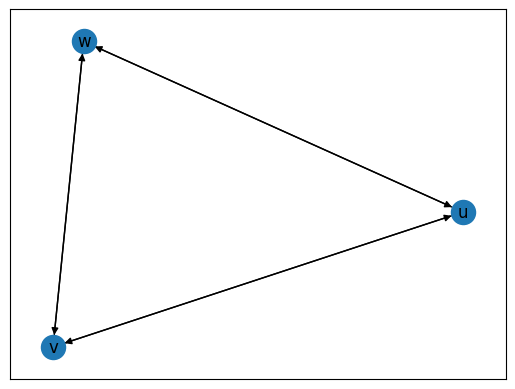

In [47]:
AAE_mixed()

In [48]:
def AAE_mixed_taxed():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/aae_example.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 1000, .1, marginal_cost_pricing=True, verbose=False)
    print(argmax_flow(probabilties_profile))

    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[246, 248, 233, 273]
[0, 1, 1, 0]
All paths:  [[['u', 'v'], ['u', 'w', 'v']], [['u', 'v', 'w'], ['u', 'w']], [['v', 'u', 'w'], ['v', 'w']], [['w', 'v'], ['w', 'u', 'v']]]
Probabilities profile:  [array([1.00000000e+00, 1.67323516e-19]), array([1.16605208e-18, 1.00000000e+00]), array([1.84773168e-06, 9.99998152e-01]), array([9.99978237e-01, 2.17626895e-05])]


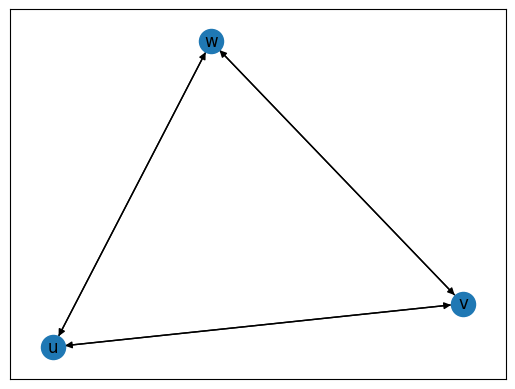

In [49]:
AAE_mixed_taxed()

In [50]:
def braess_before_mixed():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_before.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 100000, .1, verbose=False)
    print(argmax_flow(probabilties_profile))

    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[50144, 49856]
[1, 0]
All paths:  [[['s', 'v', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([1.8943408e-10, 1.0000000e+00]), array([0.99893901, 0.00106099])]


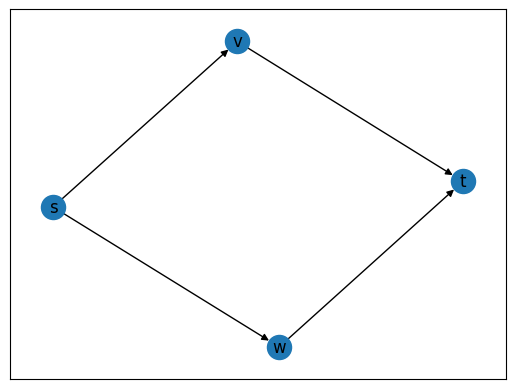

In [51]:
braess_before_mixed()

In [52]:
def no_equil_mixed():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/no_equil.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 1000, 1, verbose=False)
    print(argmax_flow(probabilties_profile))

    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[494, 506]
[1, 3]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([7.99201480e-164, 1.00000000e+000, 1.29415879e-150, 2.22407537e-161]), array([1.67980105e-11, 3.22580861e-38, 1.55153743e-38, 1.00000000e+00])]


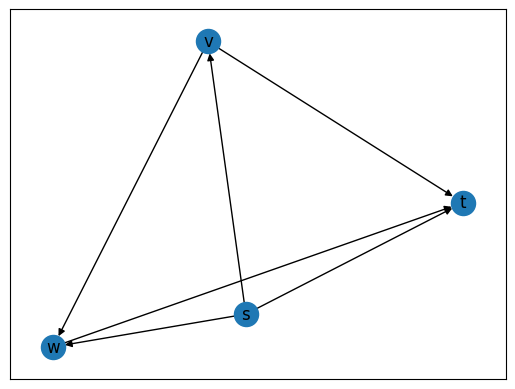

In [53]:
no_equil_mixed()

In [66]:
# optimal: 18
def test1():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/test1.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 1000, .1, marginal_cost_pricing=False, verbose=False)

    flow = argmax_flow(probabilties_profile)

    f_e, player_latencies, total_latency = calculate_edge_flows(paths, flow, demands, latency_functions)
    print(total_latency)
    print(argmax_flow(probabilties_profile))

    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[160, 170, 141, 196, 163, 170]
184
[1, 3, 3, 1, 0, 1]
All paths:  [[['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']], [['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']], [['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']], [['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']], [['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']], [['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']]]
Probabilities profile:  [array([3.31527645e-04, 9.92270720e-01, 3.04787918e-05, 7.36727386e-03]), array([1.12567380e-13, 2.91040069e-03, 2.75540767e-12, 9.97089599e-01]), array([5.17675092e-06, 6.35206620e-03, 5.47393079e-08, 9.93642702e-01]), array([2.89572305e-03, 9.97104277e-01, 5.16506114e-13, 6.12885384e-12]), array([1.00000000e+00, 8.72760829e-24, 1.26862130e-25, 2.32775890e-23]), arr

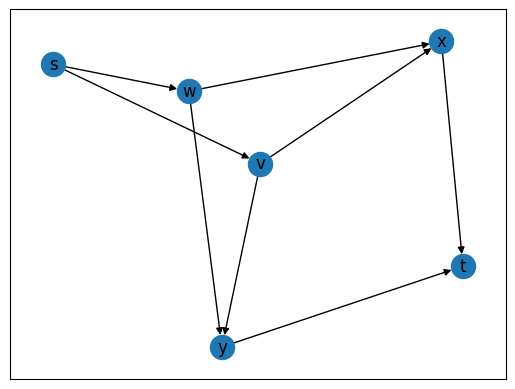

In [71]:
test1()